In [18]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import Optimizer
from IPython.display import clear_output
from tqdm import tqdm

In [19]:
df = pd.read_csv('../data/processed_data.csv')
features = list(df.columns)[:-2]
labels = list(df.columns)[-2:]

X = df[features].to_numpy()
# Note that we have 2 labels
Y = df[labels].to_numpy()

In [3]:
# The commonly used split of 75% for training, 10% for validation, and 15%
# for the test sets has been followed when splitting the dataset.
# V Roshan Joseph. Optimal ratio for data splitting. Statistical Analysis and Data Mining: The
# ASA Data Science Journal, 15(4):531–538, 2022.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.6, random_state=42)

# y1: WaveHeight
y1_train = Y_train[:,0]
y1_val = Y_val[:,0]
y1_test = Y_test[:,0]

# y2: WavePeriod
y2_train = Y_train[:,1]
y2_val = Y_val[:,1]
y2_test = Y_test[:,1]

In [4]:
def finding_polynomial(X_train, X_val, y_train, y_val, highest_degree=3):
    # define a list of values for polynomial degrees
    degrees = [i for i in range(1, highest_degree + 1)]
    # declare a variable to store the resulting validation errors for each polynomial degree
    val_errors = []
    for i in range(len(degrees)):    # use for-loop to fit polynomial regression models with different degrees

        poly = PolynomialFeatures(degree=degrees[i])
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)

        regression = LinearRegression()
        regression.fit(X_train_poly, y_train)

        y_pred = regression.predict(X_val_poly)

        val_error = mean_squared_error(y_val, y_pred)

        val_errors.append(val_error)

    return val_errors

In [5]:
val_errors_1 = finding_polynomial(X_train, X_val, y1_train, y1_val)
val_errors_2 = finding_polynomial(X_train, X_val, y2_train, y2_val)
print(val_errors_1)
print(val_errors_2)

[0.7268038850703871, 0.6709662956324683, 0.6843937345014631]
[2.0285962997894296, 1.8686333243633837, 1.8951451648206603]


In [4]:
class Network1(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(7, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)

        self.linear3 = nn.Linear(128, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.linear4 = nn.Linear(64, 2)

        self.activation = nn.ReLU()

    def forward(self, x):
        output = self.linear1(x)
        output = self.batch_norm1(output)
        output = self.activation(output)
        output = self.dropout1(output)

        output = self.linear2(output)
        output = self.batch_norm2(output)
        output = self.activation(output)
        output = self.dropout2(output)

        output = self.linear3(output)
        output = self.batch_norm3(output)
        output = self.activation(output)
        output = self.dropout3(output)

        output = self.linear4(output)

        return output

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Validation loss')

    plt.legend()

    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.show()

In [6]:
def train(model: nn.Module, data_loader: DataLoader, opt: Optimizer, loss_fn):
    model.train()

    total_loss = 0

    for i, (x, y) in enumerate(tqdm(data_loader)):
        opt.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        total_loss += loss.item()
        opt.step()

    return total_loss / len(data_loader)


In [7]:
@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()

    total_loss = 0

    for i, (x, y) in enumerate(tqdm(data_loader)):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [8]:
def fit(model, train_loader, valid_loader, opt, loss_fn, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, opt, loss_fn)
        valid_loss = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output()

        plot_stats(train_loss_history, valid_loss_history, title)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda')

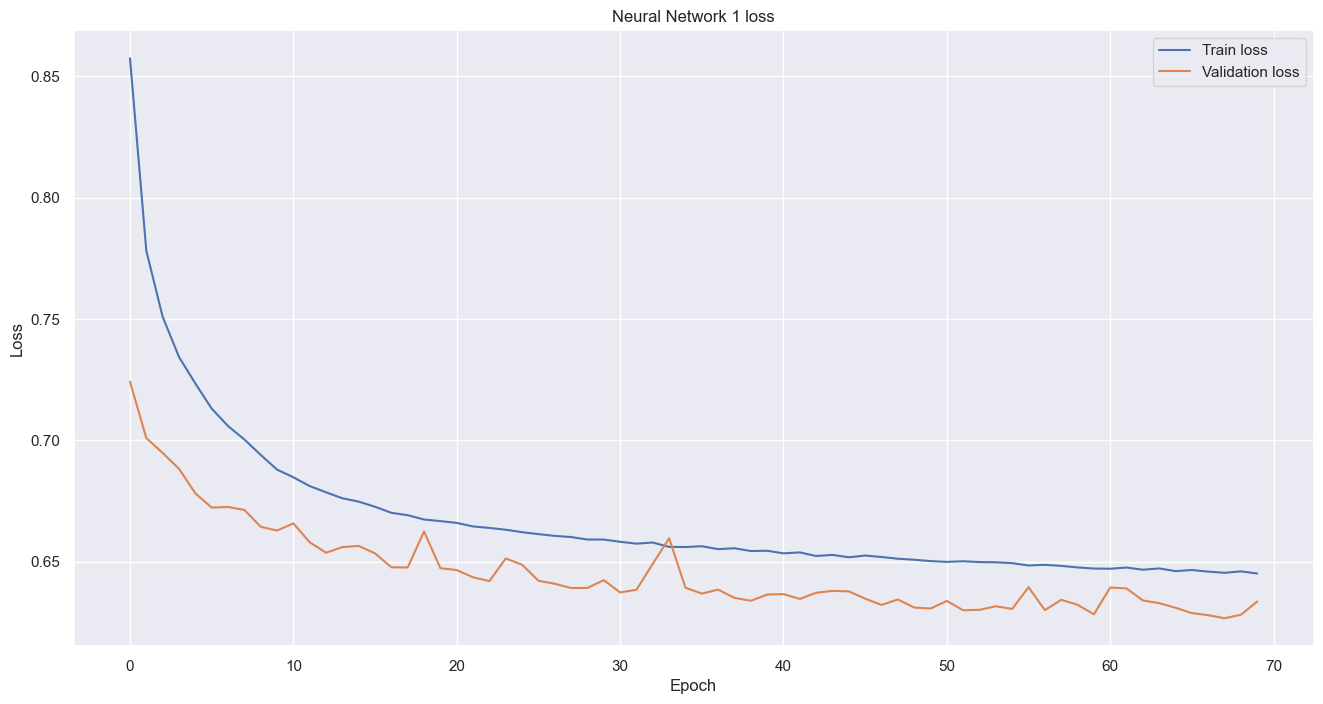

In [21]:
dataset = TensorDataset(
    torch.from_numpy(X).float().to(device),
    torch.from_numpy(Y).float().to(device)
)

train_dataset, valid_dataset = random_split(
    dataset,
    (int(len(dataset) * 0.8), len(dataset) -  int(len(dataset) * 0.8)),
    generator=torch.Generator()
)

net = Network1().to(device)

optimizer = optim.Adam(net.parameters(), lr=5e-5)
loss_function = nn.MSELoss()
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
fit(net, train_loader, valid_loader, optimizer, loss_function, 70, 'Neural Network 1')